In [245]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [246]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
from scipy import integrate
import sympy as sp
import cmath 
from itertools import repeat
from copy import deepcopy
import matplotlib.ticker as ticker
from sympy import init_printing
init_printing()

In [247]:
from linlayermodel.LLMParams import LLMParams, Constants, RadiativeComputation, ConvectiveParams, LinearSolutions
from linlayermodel.PlotSTM import PlotSTM

In [248]:
# Create intermediate cache directory using pathlib
from pathlib import Path
Path('../cache').mkdir(exist_ok=True)
# get abosulte path to cache directory
cache_dir = Path('../cache')



### Model Architecture

In [249]:
# model architecture
# nlayers = 2
# pinterfaces = np.array([1000, 900, 150])

nlayers = 3
pinterfaces = np.array([1000, 900, 500, 150])

nlayers = 4
pinterfaces = np.array([1000, 900, 500, 250, 150])

# nlayers = 5
# pinterfaces = np.array([1000, 900, 750, 500, 250, 150])

# constants
const = dict(rhoCd = 1e-3, # drag coefficient
             U = 5.0,  # reference surface wind speed
             Omega = 7.2921e-5, # rotation rate 
             theta0 = 2.5, #2.5  , # 10 degrees
             kn = 1.0, # wavenumber of forcing. k0 = 1 gives a half-cosine centered at x=0,
             Ts0 = 1e0, #K,
             x0 =  0.25e6, # m, distance of the right boundary
             DeltaTs_bar = 1e0, #K, mean sea-air temp. difference at the surface
)

# Switch propeties on/off
phys_switch = dict(WISHE_on = False, # WISHE parameter on/off
             q_on = True, # moisture parameter on/off
             Tv_on = False, # switch off virtual temp. effects
             Ts_on = True,
             TAdv_on = False, # horizontal advection on/off
             qAdv_on = False, # horizontal advection on/off
             qrad_on = 1.0, # q radiation on/off
            #  Forcing = 'Heaviside',
             Forcing = 'cosine',
             solve_xc = True) # solve for the convective boundary)

# radiation
rad_params = dict(epsilon_cre = 0.2) # cloud radiative effect

# vertical eddy transports: turbulent mixing and downdrafts
epsilon_mix = np.ones(nlayers) * 1.0e1/86400  # mixing coeff [1 per day];
epsilon_turb = np.ones(nlayers) * 0e-1/86400  # mixing coeff [1 per day];
eddy_params = dict(epsilon_turb = epsilon_turb,  # mixing coeff [1 per day]; 
                   epsilon_mix = epsilon_mix,  # vertically varying mixing
                )

epsilon_f = np.ones(nlayers) 
epsilon_f[0] = 2.5e0
epsilon_f[1:] = 2.5e-1
assert epsilon_f.size == nlayers, "epsilon_f must have the same size as nlayers"

epsilon_f = epsilon_f * 1.0/86400

# friction in the momentum equations
friction_params = dict(
                       epsilon_f = epsilon_f, # free trop. friction,
                       DT = 1e6,  #m^2/s  temperature diffusion coefficient
                       Dq = 1e6,  #m^2/s  water vapor diffusion coefficient
                       Dm = 0e6,  #m^2/s  momentum diffusion coefficient 
)

conv_params = dict(fp = 0.2)  # fraction of precipitating points. Used to scale the convective adjustment timescales

# kappa_s pert is perturbation to surface flux timescale in per s
# sbar_param is the perturbation to the background dse in K
sbar_pert = np.zeros(nlayers)
qbar_pert = np.zeros(nlayers)
epsilon_cr_pert = np.zeros((nlayers, nlayers))  # perturbation to the convective and radiative timescale matrix
pert_params = dict(kappas_pert = 0, sbar_pert = sbar_pert, 
                   qbar_pert = qbar_pert, thermo_pert = 0,
                   epsilon_cr_pert = epsilon_cr_pert)  


phys_params = conv_params | rad_params | eddy_params | friction_params | const | phys_switch | pert_params # kappa_s pert is perturbation to surface flux timescale in per s
phys_params['pinterfaces'] = pinterfaces
phys_params['nlayers'] = nlayers
phys_params['xend'] = 4e3 * 1e3 # m, distance of the right boundary
phys_params['dx'] = 10 * 1e3 # m, resolution of the x grid


# save phys parameters
SAVE = False
if SAVE:
   np.save(f'{cache_dir}/phys_params_n={nlayers}.npy', phys_params)
   print(f'Saved phys_params_n={nlayers}.npy to {cache_dir}')


#### Declare Constants

In [250]:
constants = Constants().constants

#### Radiation parameters

In [251]:
RAD = False
# radiation computation
if RAD:
    rad_dir = str( cache_dir.resolve() ) + '/'
    obj_rad  = RadiativeComputation(constants, phys_params, nlayers, pinterfaces, rad_dir)
    obj_rad.init_rad()
    obj_rad.generate_rad_coeffs()
    obj_rad.save_rad_coeffs()

#### Convection Parameters

In [252]:
CONV = False
# radiation computation
if CONV:
    import importlib.resources as res
    import linlayermodel
    lrf_file = next( res.files(linlayermodel).joinpath('data/').glob('*.mat') )
    conv_dir = str(cache_dir.resolve()) + '/'
    obj_conv = ConvectiveParams(constants, phys_params, nlayers, pinterfaces, lrf_file, conv_dir)
    obj_conv.main_conv()

### Initialize model instance with parameters

In [253]:
rad_file = str ( next ( cache_dir.resolve().glob(f'epsilon_rad_matrix_n={nlayers}.npy') ) )
conv_file = str ( next ( cache_dir.resolve().glob(f'epsilon_conv_matrix_n={nlayers}.npy') ) )
obj = LinearSolutions(constants, phys_params, nlayers, pinterfaces, rad_file, conv_file)

In [ ]:
obj.partial_solve()
# obj.create_coeff_matrices()
# obj.assign_Dm_param()
# obj.get_forced_solutions()


creating coefficient matrices
Estimating parameters for matrix evaluation
-3.3535752296447754 1.088888888888889e-06


In [ ]:
obj.get_matching_conditions()

0
1


In [ ]:
obj.thermo_x0[:, 0]

⎡                                                                              ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                  1.43876870372731⋅x_c  0.958152797023558⋅ⅈ⋅x_c               ↪
⎢1.01967415054663⋅ℯ                    ⋅ℯ                       ⋅A[7] - 0.0328 ↪
⎢                                                                              ↪
⎢                  1.43876870372731⋅x_c  0.958152797023558⋅ⅈ⋅x_c               ↪
⎢1.50564246319971⋅ℯ                    ⋅ℯ                       ⋅A[7] - 0.1874 ↪
⎢                                                                              ↪
⎢                    1.43876870372731⋅x_c  0.958152797023558⋅ⅈ⋅x_c             ↪
⎢  2.36447713352355⋅ℯ                    ⋅ℯ                       ⋅A[7] - 0.41 ↪
⎢                                                                              ↪
⎢                           

In [ ]:
obj.thermo_x0[:, 1]

⎡                           1.43876870372731⋅x_c  0.958152797023558⋅ⅈ⋅x_c      ↪
⎢         1.43876870372731⋅ℯ                    ⋅ℯ                       ⋅A[7] ↪
⎢                                                                              ↪
⎢                        1.43876870372731⋅x_c  0.958152797023558⋅ⅈ⋅x_c         ↪
⎢       1.4985293475596⋅ℯ                    ⋅ℯ                       ⋅A[7] +  ↪
⎢                                                                              ↪
⎢                          1.43876870372731⋅x_c  0.958152797023558⋅ⅈ⋅x_c       ↪
⎢        2.34584887987149⋅ℯ                    ⋅ℯ                       ⋅A[7]  ↪
⎢                                                                              ↪
⎢                                  1.43876870372731⋅x_c  0.958152797023558⋅ⅈ⋅x ↪
⎢                3.79674829889595⋅ℯ                    ⋅ℯ                      ↪
⎢                                                                              ↪
⎢                           

In [ ]:
obj.evecs['conv'][:, 0]

array([-0.03344231+0.j,  0.00983616+0.j,  0.00664219+0.j,  0.01079943+0.j,
       -0.00251919+0.j,  0.13895491+0.j, -0.47441743+0.j,  0.86846842+0.j])

In [ ]:
np.sqrt( obj.evals['conv'] )

array([34.79979514+0.j        , 28.45863882+0.j        ,
       24.99321005+0.j        , 20.00047645+0.j        ,
        8.16222089+2.91361722j,  8.16222089-2.91361722j,
        1.4387687 +0.9581528j ,  1.4387687 -0.9581528j ])

In [ ]:
obj.solve_matching_problem()
obj.get_full_solution()

ValueError: Invalid reshape parameters 16 1

In [244]:
obj.thermo_x0.shape

In [241]:
eqns = obj.eqns
xc = obj.symbols['xc']
x0_nd = obj.phys_params['x0']/obj.Lx
eqns = [eqn.subs(xc, x0_nd).evalf() for eqn in eqns]
eqns[0]

AttributeError: 'LinearSolutions' object has no attribute 'eqns'

In [242]:
vars = obj.symb
v = list(vars).copy()
v.remove(xc)
v = obj._natural_sort(v)
A, b = sp.linear_eq_to_matrix(eqns, v)

AttributeError: 'LinearSolutions' object has no attribute 'symb'

In [222]:
len(v)

In [223]:
A.shape

In [124]:
sp.exp(obj.kf * x0_nd).subs(xc, x0_nd).evalf()

In [125]:
ev = obj.evecs['conv'][:, 0]
ev / ev[0]

array([  1.        -0.j,  -0.29412335-0.j,  -0.19861647-0.j,
        -0.32292727-0.j,   0.07532947-0.j,  -4.15506311-0.j,
        14.18614374-0.j, -25.96915078-0.j])

In [216]:
obj.sol_full

### Forced solution

In [215]:
plt.scatter(obj.xrange, obj.sol_full[-1, :])

KeyError: (-1, slice(None, None, None))

/home/fiaz/miniforge3/envs/analysis/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/fiaz/miniforge3/envs/analysis/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/fiaz/miniforge3/envs/analysis/lib/python3.12/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


(2.6811030216467344-0.4087254257724335j) (-3.0014495296637564-4.356445970889378e-13j)
(-1.4703729155332341+0.03979835379786539j) (1.6903818705696074+2.2430795543265073e-13j)
(2.30494156214657-0.037014944895528305j) (-3.1835093643386374-2.729733027706692e-13j)
(-2.2103980980542377+0.3014751711327862j) (3.749237755888674+1.7241503784231653e-13j)


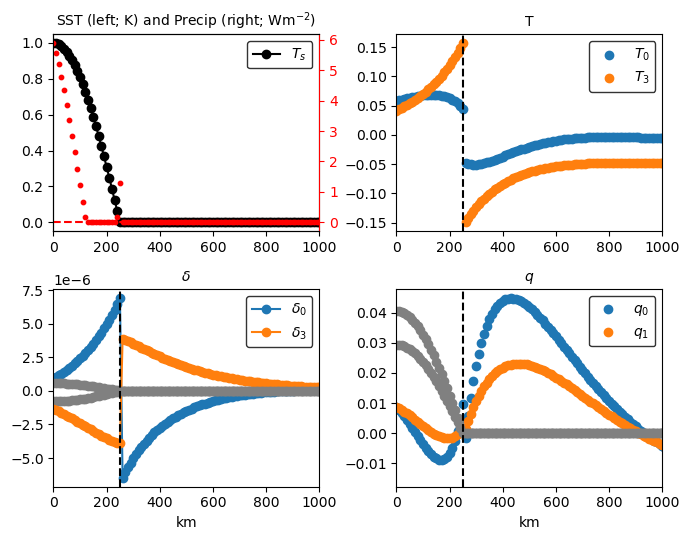

In [15]:
plot_obj = PlotSTM(obj, nlayers)
save_path = '/home/fiaz/STM/analysis/plots/Test/'
plot_obj.plot_matching(save_path, SAVE = False)

/home/fiaz/miniforge3/envs/analysis/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/fiaz/miniforge3/envs/analysis/lib/python3.12/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


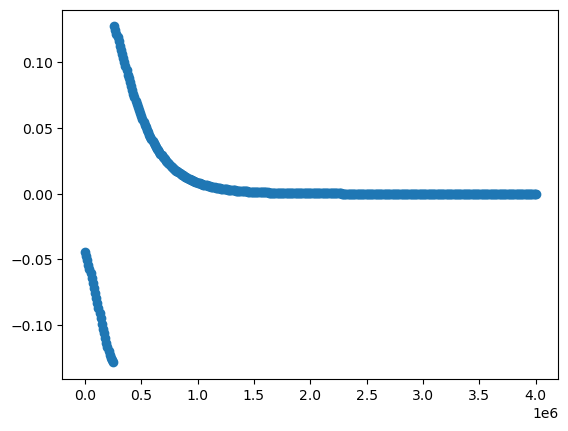

In [22]:
keys = list(obj.sol_full.keys())
plt.scatter(obj.xrange, obj.sol_full[keys[3]])

In [ ]:
# sort dict by values
# sorted_dict = dict(sorted(obj.sol_full.items(), key=lambda item: item[1]))
# obj.matching_coeffs['conv']
# sorted(obj.matching_coeffs['nconv'].items(), key = lambda item: item[1])

[(5, np.complex128(-0.0011640810643697057-5.3532929418065594e-17j)),
 (8, np.complex128(-9.2044678980699e-05-4.433459096198275e-18j)),
 (2, np.complex128(-2.1037881324342426e-05-2.392273109983915e-17j)),
 (7, np.complex128(3.047140613511642e-06+1.179523541644668e-19j)),
 (4, np.complex128(3.584574304438341e-06-1.0441553282111679e-17j)),
 (1, np.complex128(3.717809494497409e-05+5.79151376317333e-17j)),
 (3, np.complex128(0.0002939854733681604+4.507309124866444e-17j)),
 (6, np.complex128(0.0007900147570088455+2.632163663408243e-17j))]

In [ ]:
obj.evals['nconv'][7]

np.complex128(1.1519986003811091-2.7571205154925713j)

### Free solutions

In [10]:
obj.partial_solve()

creating coefficient matrices
Estimating parameters for matrix evaluation
-3.3535752296447754 1.088888888888889e-06
Getting coeff. matrices
conv
nconv
Free Solutions
0 (1211.0257420710807+0j) conv
1 (809.8941232749377+0j) conv
2 (624.6605487835941+0j) conv
3 (400.0190581372196+0j) conv
4 (58.13268459542374+47.563174774690886j) conv
5 (58.13268459542374-47.563174774690886j) conv
6 (1.1519986003811091+2.7571205154925713j) conv
7 (1.1519986003811091-2.7571205154925713j) conv
----------------------------------------
0 1210.3864567557805 nconv
1 702.4154079078994 nconv
2 615.5532271750399 nconv
3 372.32669780150366 nconv
4 78.72251843939661 nconv
5 31.259233358219014 nconv
6 5.536563196890075 nconv
7 0.16235553684624224 nconv
----------------------------------------


In [11]:
obj.get_forced_solutions()

In [70]:
obj.forced_vec['conv']

{\delta_0: np.complex128(-0.025689427938047796+0j),
 \delta_1: np.complex128(0.002501427309095894+0j),
 \delta_2: np.complex128(-0.002326483011759015+0j),
 \delta_3: np.complex128(0.01894847786699066+0j),
 T_0: np.complex128(0.00012349045553325023+0j),
 T_1: np.complex128(5.37572255818754e-06+0j),
 T_2: np.complex128(2.406293937229831e-06+0j),
 T_3: np.complex128(1.705415456272755e-05+0j),
 q_0: np.complex128(0.0006389236846965404+0j),
 q_1: np.complex128(0.0004634666694985017+0j),
 q_2: np.complex128(0.00010522191848663748+0j),
 q_3: np.complex128(1.1924651996730138e-05+0j)}

In [71]:
obj.free_vecs['conv']

{0: {T_0: np.complex128(0.0033230517802074117-0j),
  T_1: np.complex128(-0.000977387138317971-0j),
  T_2: np.complex128(-0.0006600128286868189-0j),
  T_3: np.complex128(-0.0010731040437694382-0j),
  q_0: np.complex128(0.0002503237306893102-0j),
  q_1: np.complex128(-0.01380748984802542-0j),
  q_2: np.complex128(0.047141290213593756-0j),
  q_3: np.complex128(-0.08629683274599823-0j),
  \delta_0: -2.65095188985482,
  \delta_1: 1.35467081234888,
  \delta_2: -1.16599302665552,
  \delta_3: -0.0989762033180224},
 1: {T_0: np.complex128(0.0033230517802074117-0j),
  T_1: np.complex128(-0.0006845955935045708-0j),
  T_2: np.complex128(-0.0005603530074452042-0j),
  T_3: np.complex128(-0.0008685937205964464-0j),
  q_0: np.complex128(0.044268390515597646-0j),
  q_1: np.complex128(-0.018034028220200456-0j),
  q_2: np.complex128(0.0016929154244518059-0j),
  q_3: np.complex128(0.0007308751985579951-0j),
  \delta_0: -0.733386250159085,
  \delta_1: 0.0993381520908733,
  \delta_2: -0.00537889416120574,
 

In [ ]:
# import pickle
# save_path = '/home/fiaz/STM/analysis/objects/'
# file_name = f'obj_free_modes_n={obj.nlayers}_x0={obj.phys_params["x0"] * 1e-3:.0f}km_theta={obj.phys_params["theta0"]}deg.pkl'
# with open(save_path + file_name, 'wb') as f:
#     pickle.dump(obj, f)
# print(f'Object saved as {file_name}')


Object saved as obj_free_modes_n=4_x0=250km_theta=10.0deg.pkl


#### Get forced solution for a first look

In [ ]:
obj.create_coeff_matrices()
obj.get_forced_solutions()

Estimating parameters for matrix evaluation
-3.3535752296447754 1.088888888888889e-06


Small $D_m$ limit does not approach zero $D_m$ solutions ?! Numerical errors in Python. Works fine in Mathematica

#### Save solutions to file 

/home/fiaz/anaconda3/envs/analysis_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


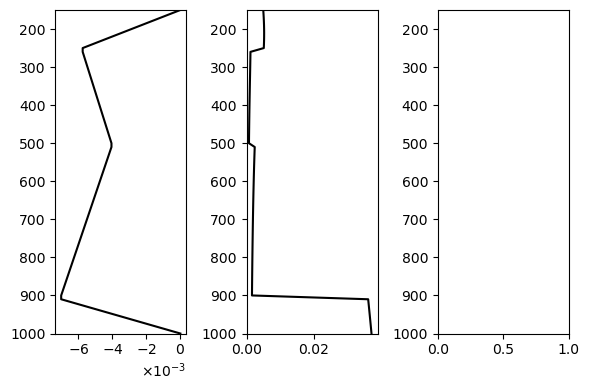

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (6, 4))

# axx, color, leg_label, SAVE = plot_kwargs['ax'], plot_kwargs['color'], plot_kwargs['leg_label'], plot_kwargs['SAVE']
plot_kwargs = dict(ax = ax, color = 'black', leg_label = 'forced', SAVE = False)

plot_obj = PlotSTM(obj, nlayers)
plot_obj.plot_forced_mode_profiles(None, **plot_kwargs)

Moving off equator likely to produce more bottom-heavy forced modes

#### Forced Mode Budgets

In [ ]:
plot_obj.plot_budgets('forced', None)

None


KeyError: 'forced'

#### Get convective and radiative heating

In [ ]:
Msb = obj.vert_struct_params['Msref'][0]
def get_col_ave_heating(obj, conv_opt: int = 1):

    taub = obj.mom_params['tau_i'][0]

    # Deltap  = obj.pinterface[0] - obj.pinterface[-1]
    # delpg = abs( np.diff(obj.pinterface) ) * 86400 / Deltap   # col-averaged heating in K/day
    # K_per_day_to_W_per_m2 = (1./86400) * obj.constants['CPD'] * Deltap * 1e2 / obj.constants['GRAVITY']
    conv_factor = np.ones((obj.nlayers)) #abs( np.diff(obj.pinterface) ) * obj.constants['CPD'] * 1e2 / obj.constants['GRAVITY']  # K/sec to W/m2; K is still non-dimensional

    rad_matrix_sT = obj.epsilon_rad_matrix[1:obj.nlayers + 1, :].T 
    rad_matrix_sq = obj.epsilon_rad_matrix[obj.nlayers + 1:, :].T * (obj.phys_params['qrad_on'])
    conv_matrix = obj.epsilon_conv_matrix

    QradT = sp.Matrix(rad_matrix_sT) @ obj.Tvec
    Qradq = sp.Matrix(rad_matrix_sq) @ obj.qvec

    # sympy.matrices.dense.matrix_multiply_elementwise(A, B), 
    Qradq_col = sp.ones(1, obj.nlayers) @ Qradq.multiply_elementwise(sp.Matrix(conv_factor))
    QradT_col = sp.ones(1, obj.nlayers) @ QradT.multiply_elementwise(sp.Matrix(conv_factor))

    Qc = conv_matrix[0, :, :]  @ obj.Tvec + conv_matrix[1, :, :] @ obj.qvec 
    Qc = Qc * conv_opt # convective heating is 0 or 1 

    return Qradq, QradT, Qc

    # Qconv_heating = sp.ones(1, obj.nlayers) @ Qc.multiply_elementwise(sp.Matrix(conv_factor))

    # Qsh = - (obj.kappa_s_star / taub) * obj.Tvec[0] * conv_factor[0]  # surface flux contribution to boundary layer budget
    # return (Qconv_heating + QradT_col + Qradq_col)[0] + Qsh

ret_list = get_col_ave_heating(obj, 1)
Qradq, QradT, Qc = [i.subs(obj.forced_vec) * Msb * 86400.0 for i in ret_list] # K/hr
Qc

⎡-33.6444455994687⋅T₀ + 28.9442967264334⋅T₁ - 0.28039742668425⋅T₂ + 0.06278543
⎢                                                                             
⎢  84.4437320806715⋅T₀ - 193.296486956882⋅T₁ + 1.8742747167097⋅T₂ - 1.79011771
⎢                                                                             
⎢ 97.4440188040977⋅T₀ - 196.852250791199⋅T₁ - 14.9196165585502⋅T₂ + 1.37501609
⎢                                                                             
⎣ 74.4616149370763⋅T₀ - 134.142465521556⋅T₁ - 3.84132265154144⋅T₂ - 9.34511509

27323324⋅T₃ + 14.6197758245552⋅q₀ - 14.6633376302689⋅q₁ + 2.15978474115032⋅q₂⎤
                                                                             ⎥
31254⋅T₃ + 166.637523170687⋅q₀ + 82.9910260957763⋅q₁ - 1.60098568295454⋅q₂   ⎥
                                                                             ⎥
175493⋅T₃ + 187.524648200971⋅q₀ + 114.699729784803⋅q₁ + 21.9386525533447⋅q₂  ⎥
                                                   

Note sources of degeneracy in the matching conditions:
- In the convective region solutions with the same eigenvectors cannot be separated (linearly dependent column vectors in the A matrix) 
- The matching conditions themselves are not linearly independent (linearly dependent row vectors in the A matrix)
- Degenerate eigenvectors need not yield degenerate matching conditions, if derivatives (or more generally: dependence on odd powers of $k$) are involved
- However, if one invokes a symmetry argument within the convective zone, the coefficients of $\pm k$ will have to be equal.


NameError: name 'QradT' is not defined

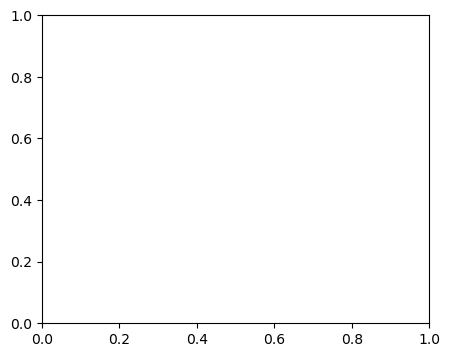

In [ ]:
fig, axx = plt.subplots(1, 1, figsize = (5, 4))
ax = axx
ax.plot(QradT, np.arange(obj.nlayers), label = 'Radiative heating', c = 'red', marker = 'o')
ax.plot(Qradq, np.arange(obj.nlayers), label = 'Radiative heating', c = 'blue', marker = 'o')
ax.plot(Qc, np.arange(obj.nlayers), label = 'Convective heating', c = 'black', marker = 'o')
ax.vlines(0, 0, obj.nlayers -1 , colors = 'grey', linestyle = '--')
# y axis major tick locator
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))


/home/fiaz/STM/analysis/PlotSTM.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_ylabel('hPa', fontsize = 12)
/home/fiaz/STM/analysis/PlotSTM.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_ylabel('hPa', fontsize = 12)
/home/fiaz/STM/analysis/PlotSTM.py:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticks(np.arange(0.5, obj.nlayers + 0.5, 1))
/home/fiaz/STM/analysis/PlotSTM.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fil_out = f'{save_path}conv_matrix_n={obj.nlayers}.pdf'


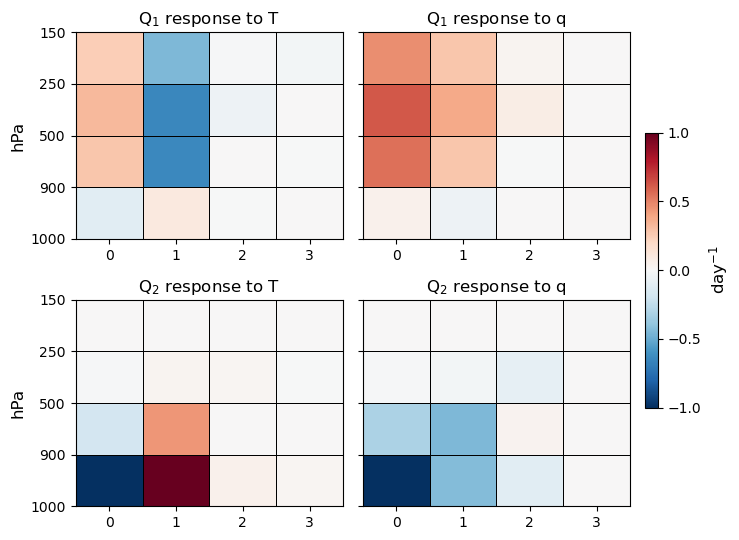

In [ ]:
plot_obj = PlotSTM(obj, nlayers)
save_path = '/home/fiaz/STM/analysis/plots/Test/'
plot_obj.plot_conv_kernel(save_path)

/home/fiaz/STM/analysis/PlotSTM.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


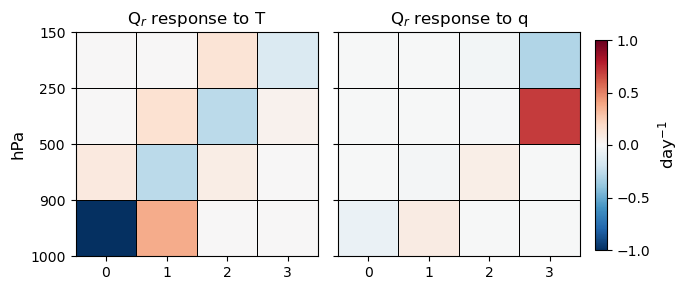

In [ ]:
plot_obj.plot_rad_kernel(save_path)

/home/fiaz/STM/analysis/PlotSTM.py:125: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(obj.pinterface)
/home/fiaz/STM/analysis/PlotSTM.py:134: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(obj.pinterface)
/home/fiaz/STM/analysis/PlotSTM.py:143: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(obj.pinterface)
/home/fiaz/STM/analysis/PlotSTM.py:169: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(0, obj.nlayers, 1))
/home/fiaz/STM/analysis/PlotSTM.py:184: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


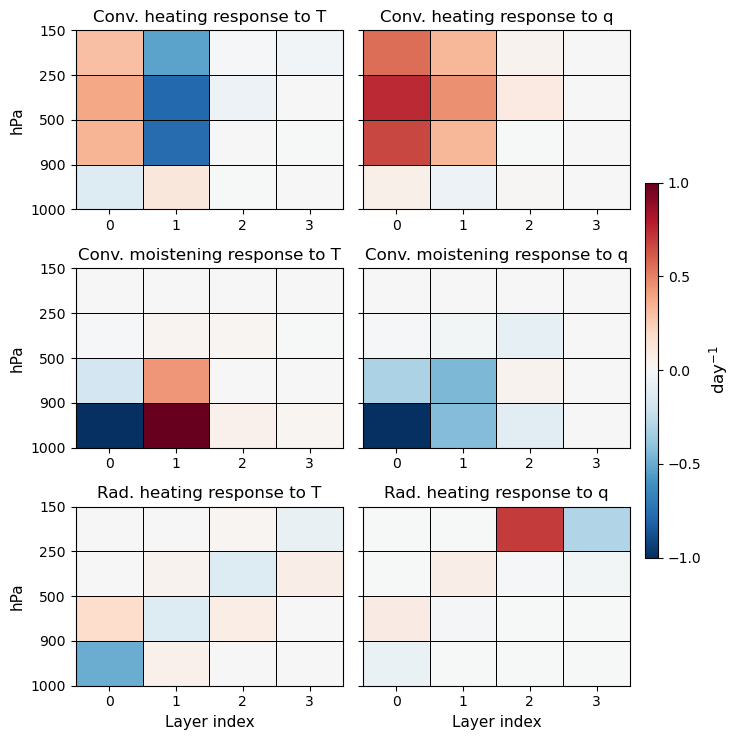

In [ ]:
plot_obj = PlotSTM(obj, nlayers)
save_path = '/home/fiaz/STM/analysis/plots/'
plot_obj.plot_rad_conv_kernel(save_path, SAVE = False)

### Full solution

In [ ]:
obj = LinearSolutions(constants, phys_params, nlayers, pinterfaces, rad_file, conv_file)
obj.linear_solve()

creating coefficient matrices
Estimating parameters for matrix evaluation
-3.3535752296447754 1.088888888888889e-06
Getting coeff. matrices
conv
nconv
Free Solutions
Polynomial degree: 16
16 solutions
0 (-34.79950917288944+0j) conv
1 (34.79950917288951+0j) conv
2 (-28.458633405922534+0j) conv
3 (-24.993220082694265+0j) conv
4 (-20.000691044372054+0j) conv
5 (28.458633405922726+0j) conv
6 (24.99322008269416+0j) conv
7 (20.000691044372076+0j) conv
8 (-8.162254584215457+2.9138248422493405j) conv
9 (-8.162254584215457-2.9138248422493405j) conv
10 (8.162254584215454+2.913824842249353j) conv
11 (8.162254584215454-2.913824842249353j) conv
12 (-1.4387563316123795+0.9583668450360151j) conv
13 (-1.4387563316123795-0.9583668450360151j) conv
14 (1.4387563316123804+0.958366845036017j) conv
15 (1.4387563316123804-0.958366845036017j) conv
----------------------------------------
Polynomial degree: 16
16 solutions
0 -34.790313234476145 nconv
1 -26.503125697926432 nconv
2 -24.810350857385117 nconv
3 -1

In [ ]:
sols_x0, v  = obj.get_Ab_x0(obj.eqns, obj.vars)  # For xc = x0, get sols and b
eqs = obj.eqns.copy()
eqs.append( obj.Qc_eqns )
nonlinear_sol = sp.nsolve(eqs, v, sols_x0, nsteps = 1000)
# sols_temp, v_temp = obj.non_linear_solve_xc(initial_guess, eqns, v, aux_eqn)  # solution for xc != x0 using sols as initial guess

Matrix Condition number: 3.271275870161156e+17
Determinant: (-3.2884422505611756e+132+8.356600174560873e+149j)


ValueError: Could not find root within given tolerance. (0.000587396365830988108023 > 2.16840434497100886801e-19)
Try another starting point or tweak arguments.

#### Plot matching solution

Could the key to solving the divergence at boundary problem lie in how we treat the degeneracy of $\pm k$ eigenvectors?<br>
The matching conditions are not linearly dependent for the $\pm k$ eigenvectors if the derivatives appear in the matching conditions. Including these eigenvectors as distinct contributions introduces another set of issues such as large blowups

/home/fiaz/anaconda3/envs/analysis_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/fiaz/anaconda3/envs/analysis_env/lib/python3.9/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


(-0.3061170371438976-0.40872849999406424j) (0.023446566498545936+4.786344852583602e-17j)
(0.03459893219900842+0.03980018836463019j) (0.010492673197434115-6.022953998886749e-17j)
(0.010844507495982631-0.037021737503077495j) (0.00618822324968718+3.3095236414037437e-17j)
(0.11454267986301761+0.3014870853799859j) (-0.07687507111793335+1.1238953488964095e-16j)


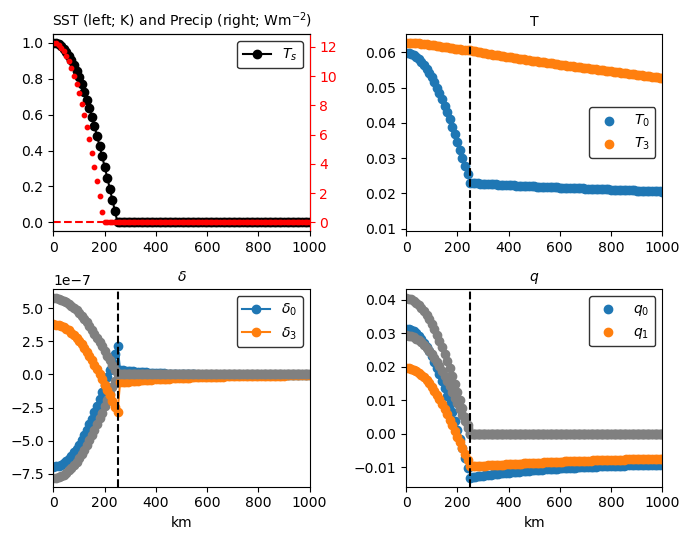

In [ ]:
plot_obj = PlotSTM(obj, nlayers)
save_path = '/home/fiaz/STM/analysis/plots/Test/'
plot_obj.plot_matching(save_path, SAVE = False)

How can we impose continuity at $x=0$ ? For instance, $dqdx$ appears discontinuous at $x=0$, suggesting that the Diffusion may not be well-defined.

Continuity of divergence versus continuity of moisture

Why do the weights shift to the shortest modes?

/home/fiaz/anaconda3/envs/analysis_env/lib/python3.9/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


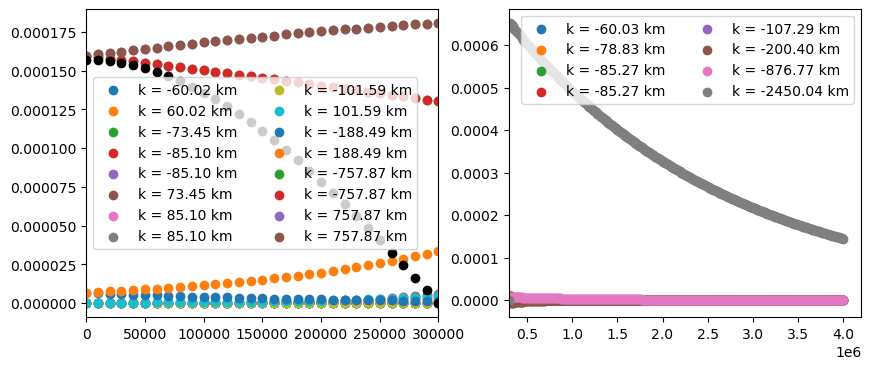

In [ ]:
symb = obj.Tvec[0]
fig, axx = plt.subplots(1, 2, figsize = (10, 4))

ax = axx[0]
for k in obj.matching_coeffs['conv'].keys():
    ax.scatter(obj.xrange, obj.sol_modal['conv'][k][symb], label = f'k = {obj.decay_scales["conv"][k]:.2f} km')
ax.scatter(obj.xrange, obj.sol_modal['forced'][0][symb], color = 'k')
ax.set_xlim(left = 0, right = obj.x0)
ax.legend(ncol = 2)

ax = axx[1]
for k in obj.matching_coeffs['nconv'].keys():
    ax.scatter(obj.xrange, obj.sol_modal['nconv'][k][symb], label = f'k = {obj.decay_scales["nconv"][k]:.2f} km')
ax.set_xlim(left = obj.x0)
ax.legend(ncol = 2)

#### Plot matched weights

/home/fiaz/anaconda3/envs/analysis_env/lib/python3.9/site-packages/matplotlib/transforms.py:762: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


KeyError: T_0

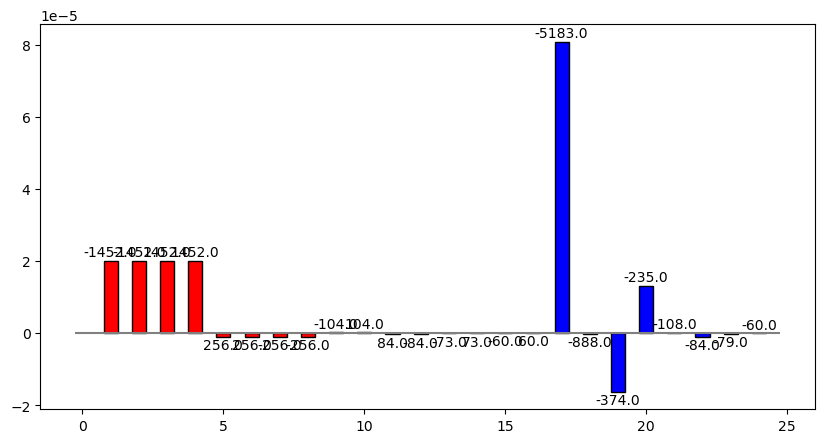

In [ ]:
plot_obj.plot_matching_weights(save_path, SAVE = False)

#### Plot Omega(x, p)

/home/fiaz/STM/analysis/PlotSTM.py:539: ComplexWarning: Casting complex values to real discards the imaginary part
  omega_full[xi, :], _ = obj.compute_omega_profile(div_temp)
/home/fiaz/STM/analysis/PlotSTM.py:542: ComplexWarning: Casting complex values to real discards the imaginary part
  omega_forced[xi, :], _ = obj.compute_omega_profile(div_temp)


[-6. -5. -4. -3. -2. -1.  0.]


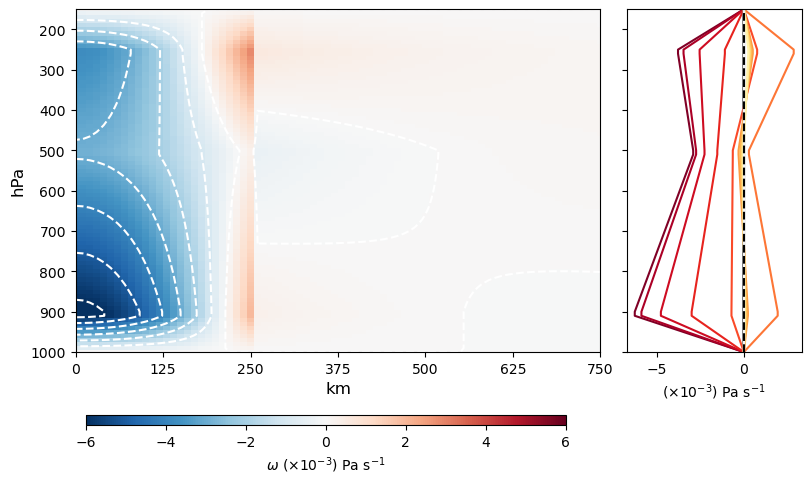

In [ ]:
plot_obj = PlotSTM(obj, nlayers)
plot_obj.plot_omega(save_path, '_', SAVE = False)

### Free Modes

The two slowest decaying modes have similar omega profiles (eigenvectors)

/home/fiaz/anaconda3/envs/analysis_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


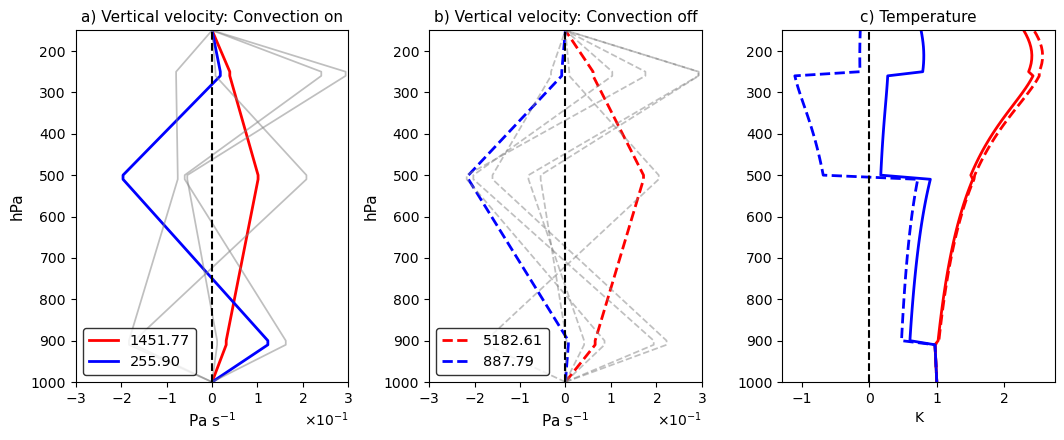

In [ ]:
plot_obj = PlotSTM(obj, nlayers)
plot_obj.plot_free_modes(save_path, SAVE = False)

In [ ]:
import pickle
save_path = '/home/fiaz/STM/analysis/objects/'
file_name = f'obj_n={obj.nlayers}_x0={obj.phys_params["x0"] * 1e-3:.0f}km_theta={obj.phys_params["theta0"]}deg.pkl'
with open(save_path + file_name, 'wb') as f:
    pickle.dump(obj, f)
print(f'Object saved as {file_name}')


Object saved as obj_n=4_x0=250km_theta=2.5deg.pkl


'obj_n=4_x0=250km_theta=2.5deg.pkl'

In [ ]:
obj.vert_struct_params['a_profiles']

{0: array([1.        , 0.99711959, 0.99423917, 0.99132565, 0.98841213,
        0.9854655 , 0.98248576, 0.97947292, 0.97646007, 0.97341412]),
 1: array([1.        , 1.00644875, 1.01320459, 1.02016514, 1.0272963 ,
        1.03463218, 1.04220691, 1.04995223, 1.0579364 , 1.06615941,
        1.07462126, 1.08335608, 1.09232974, 1.10161048, 1.11116419,
        1.12102498, 1.13122697, 1.14173604, 1.15262044, 1.16388017,
        1.1754811 , 1.18752559, 1.20001365, 1.21291115, 1.22632046,
        1.24017333, 1.25460625, 1.26955098, 1.28510987, 1.30128293,
        1.31807015, 1.3355739 , 1.35379419, 1.37276512, 1.39252081,
        1.41316364, 1.4346936 , 1.45717893, 1.48061963, 1.50515218]),
 2: array([1.        , 1.01751961, 1.03581937, 1.05494383, 1.07495988,
        1.0958898 , 1.11775588, 1.14058042, 1.16440799, 1.18923859,
        1.21509451, 1.24193117, 1.26970399, 1.29841298, 1.3279021 ,
        1.3580822 , 1.38877496, 1.4197352 , 1.45071772, 1.48136591,
        1.51125624, 1.53996523, 1.5

In [ ]:
obj.free_vecs['conv']

⎧                                                                             
⎨0: {T₀: 300.92820278608946, T₁: -88.5086090190443, T₂: -59.7848546000075, T₃:
⎩                                                                             

                                                                              
 -97.1263723352334, \delta₀: -240057.977985508, \delta₁: 122659.117459622, \de
                                                                              

                                                                              
lta₂: -105328.443435299, \delta₃: -9530.11366085823, φ₁: 499.158442739646, φ₂:
                                                                              

                                                                              
 -824.461329571301, φ₃: -1936.17707317202, φ₄: -3009.36453679972, q₀: 25.11761
                                                                              

                                                

In [ ]:
plot_obj.plot_budgets('nconv', None, 8)

8


KeyError: 8

#### Matrix for u-wind, $\phi$ and $\delta$

In [ ]:
eqns = []
for key in obj.uwind_dict.keys():
    eqns.append(obj.uwind_dict[key])
A, b = sp.linear_eq_to_matrix( eqns, list(obj.Tvec) )
num = A.det().as_numer_denom()[0]
sp.simplify(num)
# the n u-equations are not linearly independent; use n-1


##### $\phi$

In [ ]:
eqns = []
for n, key in enumerate(obj.phi_dict.keys()):
    # if n == 4:
    #     continue
    eqns.append(obj.phi_dict[key])

A, b = sp.linear_eq_to_matrix( eqns, list(obj.Tvec) )
A.det().subs(obj.params_dict['general'])
# the n phi-equations are not linearly independent (although determinant \ne 0); use n-1

##### $\delta$ equations

In [ ]:
eqns = []
for n,k in enumerate(obj.delta_sols.keys()):
    eqns.append(obj.delta_sols[k])

A, b = sp.linear_eq_to_matrix( eqns, list(obj.Tvec) )
## the four delta-equations are not linearly independent; use three?
A = A/pow(obj.ksymb,2)
A
eqns

##### Diagnose singular Matrix

In [ ]:
Am = sp.Matrix(obj.Asol)
for i in range(Am.shape[0]):
    Am = Am.elementary_row_op('n->kn', row=i, k=1/Am[i,0])
Am


##### Diagnose u-wind at $x_0$

In [ ]:
ux0_plus = np.zeros((obj.nlayers), dtype = complex)
ux0_minus = np.zeros((obj.nlayers), dtype = complex)

for key in ['forced', 'conv', 'nconv']:
    
    for n in range(obj.nlayers - 1):
        # var_x0 = obj.u_x0[key][n]
        var_x0 = obj.phi_x0[key][n]
        # var_x0 = obj.delta_domain[key][n]

        if key in ['conv', 'nconv']:
            try:
                symbols = var_x0.free_symbols
            except:
                continue

            matching_conds = obj.matching_coeffs[key]
            symbols.discard(sp.symbols('A'))
            symbols.discard(sp.symbols('B'))
            sign = 1 
            # if key == 'nconv' else 1
            if key == 'conv':
                ux0_minus[n] += (sign * complex(var_x0.subs({s : matching_conds[s.indices[0]] for s in symbols})))
            else:
                ux0_plus[n] += (sign * complex(var_x0.subs({s : matching_conds[s.indices[0]] for s in symbols})))
        
        else:
            ux0_minus[n] += complex(var_x0)

ux0_minus, ux0_plus

### The forcing as  $x_f\to\infty$

-0.6481649540009209


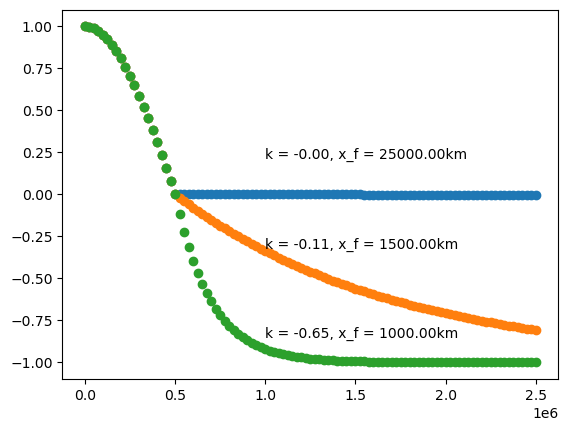

In [ ]:
# For what value of k does the domain mean of Ts -> 0?
# For Ts in the non-convective region given by exp(k(x - x0)) - 1, we can find the value of k that makes the mean of Ts = 0
# As x_f -> infty, k -> 0, giving back the original forcing function we have used.

x = obj.xrange
Ts = lambda x, k:  (np.exp(k * (x - obj.x0) /obj.Lx) - 1) * np.heaviside(x - obj.x0, 0)  + np.exp(obj.kf * x/obj.Lx) * np.heaviside(obj.x0 - x, 0)
Ts_conv = lambda x, k: np.real( np.cos(np.imag(obj.kf) * x/obj.Lx) * np.heaviside(obj.x0 - x, 0) )

from scipy import optimize
def func(k, kf, x0, xf):
    delta_xf = (xf - x0)
    conv = -np.sin(kf * x0)/kf
    nconv = ( 1 - np.exp( k * delta_xf) ) / k +  delta_xf 
    return conv + nconv

args = (np.imag(obj.kf), obj.x0/obj.Lx, obj.xend * 1e1 /obj.Lx)
k = optimize.newton(func, 0.05, args = args)
y = Ts(x, k)
plt.scatter(x, y)
plt.text(2 * obj.x0, -1e2 * y[-1], f'k = {k:.2f}, x_f = {args[2] * obj.Lx * 1e-3:.2f}km')

args = (np.imag(obj.kf), obj.x0/obj.Lx, obj.xend * 0.6 /obj.Lx)
k = optimize.newton(func, 0.05, args = args)
y = Ts(x, k)
plt.scatter(x, y)
plt.text(2 * obj.x0, 0.4 * y[-1], f'k = {k:.2f}, x_f = {args[2] * obj.Lx * 1e-3:.2f}km')


args = (np.imag(obj.kf), obj.x0/obj.Lx, obj.xend * 0.4 /obj.Lx)
k = optimize.newton(func, 0.05, args = args)
y = Ts(x, k)
plt.scatter(x, y)
plt.text(2 * obj.x0, 0.85 * y[-1], f'k = {k:.2f}, x_f = {args[2] * obj.Lx * 1e-3:.2f}km')




# plt.scatter(x, Ts_conv(x, k))

print(k)